In [1]:
from frame_postprocess import *

set_plot_formatting()
color_specs = ['tab:red','tab:green','tab:orange','tab:purple','tab:olive'] #
# color_specs = [(56/255, 95/255, 150/255), (207/255, 89/255, 33/255), (231/255, 184/255, 0/255), (158/255, 184/255, 219/255),
#                (128/255, 0/255, 0/255)]

# GENERAL INPUTS

Building geometry and relevant properties

In [3]:
############### Bldg ###############
bldg_name = 'Example_Bldg1'
only_collapses = False
rp_plot = '975'   # stripe to plot response
gm_tag = 5 # gm tag to plot
####################################

## Locate inputs and results folder ##
raw_folder_name = '1_Raw_NLRHA_results'
EDP_folder_name = '2_Collected_NLRHA_results'
bldg_info = pd.read_csv(os.path.join(raw_folder_name, 'building_info_for_plot.csv'))

## Retrieve inputs for plots ##
case_i = np.argwhere(bldg_info['OBJECTID'].to_numpy() == int(bldg_name[-1]))[0][0]
splice        = bldg_info['splice'].iloc[case_i]

story_heights = np.array(eval(bldg_info['storyHeight'].iloc[case_i]))
n_stories = len(story_heights)
beam_list   = np.array(eval(bldg_info['beam_list'].iloc[case_i]))
column_list = np.array(eval(bldg_info['column_list'].iloc[case_i]))
bay_widths  = np.array(eval(bldg_info['bayWidth'].iloc[case_i]))
n_bays      = len(bay_widths) 

In [5]:
# results folder name
results_filename  = os.path.join(EDP_folder_name, bldg_name + '.h5')

## PLOT FRAME RESPONSE IN ELEVATION

In [6]:
############ INPUTS ################
marker_size = 50 # size marker for fractures
t           = 0 # time step to plot if results include all time history
plot_scale  = 10
####################################

In [7]:
# element coordinates
n_stories, n_bays, columns, beams, joints_x, joints_y = get_coordinates(beam_list, column_list, bay_widths, story_heights)

# Define plotting function
def plot_end_state(column_response, pz_response, beam_response, title_text, title_color='k'):    
                          
    # Displacement table
    edp = pz_response['all_disp']
    
    # Adjust EDP if there are beams extending two bays
    if edp.ndim == 3:
        edp = edp[:, :, t]
        
    n_floors, n_piers = edp.shape
    n_stories = n_floors - 1
    n_bays = n_piers - 1
    for i_story in range(n_stories):
        for i_bay in range(n_bays):
            if (beam_list[i_story, min(i_bay + 1, n_bays - 1)] == 0) and \
                    (column_list[i_story, min(i_bay + 1, n_bays)] == 0) and \
                    (column_list[min(i_story + 1, n_stories - 1), min(i_bay + 1, n_bays)] == 0):
                # for double bay beams
#                 print(edp[i_story+1, i_bay + 2])
                edp[i_story+1, min(i_bay + 1, n_bays)] = edp[i_story+1, i_bay+2] 
    
    # Plot response
    plot_building_at_t(t, edp, columns, beams, plot_scale, column_list, beam_list, ax, x_gap=800)
    plot_fractures_edp(ax, t, edp, joints_x, joints_y, beam_response, plot_scale=plot_scale, marker_size=marker_size,
                      one_fracture_color=color_specs[0], both_fractures_color='k')
    plot_column_response_bins_edp(ax, t, edp, joints_x, joints_y, column_response['hinge_bot'], 
                            column_response['hinge_top'], labelText='$\\theta_p$', plot_scale=plot_scale,
                           max_marker_size=marker_size, bins=np.array([0, 0.0025, 0.01, 0.02]), edgecolor='grey', 
                            facecolors='lightgrey', addLegend=False)
    plot_column_response_bins_edp(ax, t, edp, joints_x, joints_y, pz_response['pz_rot'],
                          np.zeros(pz_response['pz_rot'].shape), d_y=0, max_value=1, 
                          max_marker_size=marker_size, plot_scale=plot_scale, 
                          labelText='$\\theta_p$', bins=np.array([0, 0.005, 0.01, 0.02]), addLegend=False)
    
    _ = ax.set_title(title_text, color=title_color)
    plt.tight_layout()
    plt.show()


-------------------------------
RETURN PERIOD = 975
-------------------------------


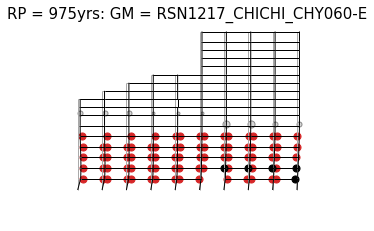

In [9]:
# plot frame shape after each return period
    
# collect EDP file to avoid non-convergence cases
edp_filename  = 'EDP_' + bldg_name + '_' + rp_plot +'.csv'
results_path  = os.path.join(EDP_folder_name, edp_filename)
results_build = pd.read_csv(results_path)
endCriteria   = results_build['EndCriteria'].to_numpy()

# collect list of gms at this return period
with h5py.File(results_filename, 'r') as hf:
    gm_ids = list(hf[rp_plot].keys())
gm_ids = np.array(gm_ids )
    
print('-------------------------------')
print('RETURN PERIOD = ' + rp_plot)
print('-------------------------------')

# plot end state of the frame after each gm
gm_id = gm_ids[gm_tag]

if gm_id in gm_ids:
    endCriteria_gm = endCriteria[gm_ids == gm_id][0]        
else:
    endCriteria_gm = 'not_finished'

# Decide if plotting or not according to inputs
if only_collapses and endCriteria_gm == 'MaxDrift':
    # Plots only collapses
    plot_flag = True  
elif only_collapses and endCriteria_gm != 'MaxDrift':
    plot_flag = False
elif ~only_collapses and endCriteria_gm != 'Inconvergence' and endCriteria_gm != 'not_finished':
    # Plots all cases that ran well
    plot_flag = True 
else:            
    plot_flag = False    
        

# Collect data and plot end state of the frame
if plot_flag:                        

    pz_response = {}
    column_response = {}
    beam_response = {}

    # collect results
    with h5py.File(results_filename, 'r') as hf:
        key = 'all_disp'
        pz_response[key] = hf[rp_plot][gm_id][key][()]
        key = 'pz_rot'
        pz_response['pz_rot'] = hf[rp_plot][gm_id][key][()]

        key = 'hinge_bot'
        column_response['hinge_bot'] = hf[rp_plot][gm_id][key][()]
        key = 'hinge_top'
        column_response['hinge_top'] = hf[rp_plot][gm_id][key][()]

        key = 'frac_LB'
        beam_response['frac_LB'] = hf[rp_plot][gm_id][key][()]
        key = 'frac_LT'
        beam_response['frac_LT'] = hf[rp_plot][gm_id][key][()]
        key = 'frac_RB'
        beam_response['frac_RB'] = hf[rp_plot][gm_id][key][()]
        key = 'frac_RT'
        beam_response['frac_RT'] = hf[rp_plot][gm_id][key][()]

    # plot frame
    fig, ax = plt.subplots(1, 1, figsize=(5,5))

    if endCriteria_gm == 'MaxDrift':
        title_text = 'COLLAPSE: RP = ' + str(rp_plot) + 'yrs:\nGM = ' + gm_id
        title_color = 'r'
    else:
        title_text = 'RP = ' + str(rp_plot) + 'yrs: GM = ' + gm_id
        title_color = 'k'

    plot_end_state(column_response, pz_response, beam_response, title_text, title_color)
    
    _ = fig.savefig('3_Output_figures/Elevation_'+'_RP'+rp_plot+'_GM'+str(gm_tag)+'.png', transparent=True) 
    
else:
    print('THIS GROUND MOTION DID NOT COLLAPSE')

## Plot response in height

In [10]:
############ INPUTS ################
EDPperStory = 'PID' # PID PFA
g = 386
edp_limits = [0, 0.05]
rid_max    = 0.05
cases_to_plot = 'nonCollapse' # nonCollapse MaxDrift Inconvergence  
####################################

In [15]:
with h5py.File(results_filename, 'r') as hf:
    rp_list = list(hf.keys())
    
# load results per stripe
results = {}
for rp in rp_list:    
    try:
        filename = 'EDP_' + bldg_name + '_' + str(rp) +'.csv'
        results_path = os.path.join(EDP_folder_name, filename)
        results[rp] = pd.read_csv(results_path)
    except:
        print('Skip rp=' + rp)

array([0.03475654, 0.03222061, 0.0265447 , 0.01718615, 0.01121305,
       0.00782315, 0.00639559, 0.00500119, 0.00490876, 0.0050873 ,
       0.00523347, 0.00585232, 0.00723441, 0.0075704 , 0.00664541,
       0.00523899, 0.00311877, 0.00311877])

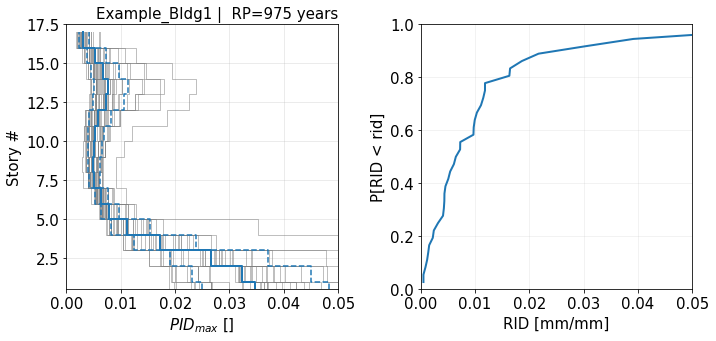

In [16]:
fig, ax_list = plt.subplots(1,2, figsize=(10,5)) 

# Read results
res = results[rp_plot]
endCriteria = res['EndCriteria'].to_numpy()
n_records, _ = res.shape

######## Plot requested EDP per story ########
dir_i = 1
color_stats = 'tab:blue'

# Get index for floor response
idx = []
for i in range(len(res.columns)):
    idx.append((EDPperStory in res.columns[i]) and (res.columns[i][-1] == str(dir_i)))

# Read response per record
edp2plot = []
res_np = res.to_numpy()
for record_i in range(n_records):
    if endCriteria[record_i] == cases_to_plot: #nonCollapse MaxDrift Inconvergence            
        if EDPperStory == 'PFA':
            aux = res_np[record_i,idx]/g
        else:
            aux = res_np[record_i,idx]
        edp2plot.append(aux)                    

# Figure
ax = ax_list[dir_i-1]          
title_text = bldg_name + ' |  RP=' + rp + ' years'#'CVN='+str(cvn_list[case_i])+'ft-lb, $a_0='+str(a0_list[case_i])+'t_f$\nTr = '+str(rp_list[rp_i])+'yrs'+' Dir '+str(Dir)        

if edp2plot == []:
    print('All ground motions collapsed')
else:
    plot_response_in_height(EDPperStory, edp2plot, title_text, edp_limits, ax, color_record='grey', color_stats=color_stats)

######## Plot RIDmax for direction X and Y ########
ax = ax_list[-1]

# Initialize figure   

# Initialize variables for plotting
edp2plot = []

# Read results
res = results[rp]
endCriteria = res['EndCriteria'].to_numpy()

# Get index for floor response
idx = []
for i in range(len(res.columns)):
    idx.append(('RID' in res.columns[i]) and ('1' == res.columns[i][-1]))
n_stories = sum(idx)

# Get peak interstory drift profile per GM that qualifies for plotting          
n_records, _ = res.shape 
res_np = res.to_numpy()

for record_i in range(n_records):

    plot_record = False
    if endCriteria[record_i] == 'nonCollapse':
        plot_record = True

    if plot_record == True:
        edp2plot.append(res_np[record_i,idx])

edp2plot = np.array(edp2plot).flatten()

# Figure                    
if edp2plot.size == 0:
    print('No ground motions to plot')
else:                     
    color_name = 'tab:blue'

    x = np.sort(edp2plot)
    n = x.size
    y = np.arange(1, n+1) / n
    _ = ax.plot(x, y, linewidth=2, color=color_name, alpha=1)            
    _ = ax.set_xlabel('RID [mm/mm]')
    _ = ax.set_ylabel('P[RID < rid]')
    _ = ax.set_ylim([0, 1])
    _ = ax.set_xlim([0, rid_max])

_ = ax.grid(which='both', alpha=0.2)        

_ = plt.tight_layout()    
_ = plt.show()
_ = fig.savefig('3_Output_figures/PID_RID_'+'_RP'+rp+'.png', transparent=True) 

## PID distribution of collapsed cases to higlighting critical stories

In [17]:
############ INPUTS ################
endCriteriaToPlot = 'MaxDrift' # All nonCollapse MaxDrift Inconvergence
EDP = 'PID' # 'PID' 'PFA'
edp_limits = [0, 0.05] #999 [0, 0.12] [0, 0.5]
critical_EDP = 0.05
####################################

Plot  PID  for records that ended as: MaxDrift
Plot  PID  for the return periods: 


array([0.05571816, 0.05130322, 0.04232376, 0.02183416, 0.01210767,
       0.00768356, 0.00584213, 0.00447723, 0.00435266, 0.00447671,
       0.00461643, 0.00501949, 0.00606157, 0.00623677, 0.00548273,
       0.00435901, 0.00259915, 0.00259915])

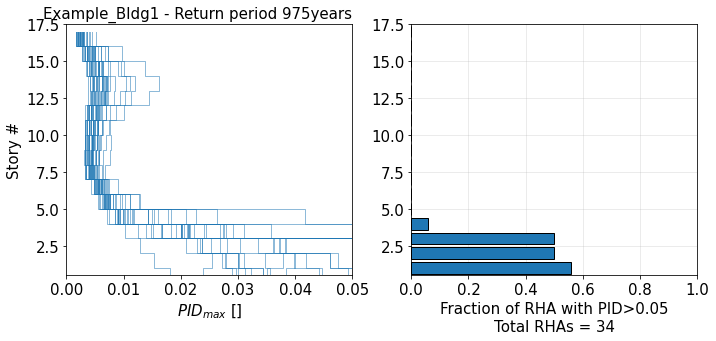

In [18]:
print('Plot ', EDP, ' for records that ended as: ' + endCriteriaToPlot)
print('Plot ', EDP, ' for the return periods: ')

# Initialize figure
fig, ax_list = plt.subplots(1,2, figsize=(10,5)) 
title_text = bldg_name + ' - Return period ' + rp_plot + 'years'

# Initialize variables for plotting
edp2plot = []

# Read results
res = results[rp_plot]
endCriteria = res['EndCriteria'].to_numpy()            

# Get index for floor response
idx = []
for i in range(len(res.columns)):
    idx.append((EDP in res.columns[i]) and ('1' == res.columns[i][-1]))
n_stories = sum(idx)

# Get EDP profile per GM that qualifies for plotting          
n_records, _ = res.shape 
res_np = res.to_numpy()

for record_i in range(n_records):

    plot_record = False
    if endCriteria[record_i] == endCriteriaToPlot: #nonCollapse MaxDrift Inconvergence
        plot_record = True
    elif endCriteriaToPlot == 'All':
        plot_record = True

    if plot_record == True:
        if EDP == 'PFA':
            unit_factor = 386 # from in/s2 to g
        else:
            unit_factor = 1
        edp2plot.append(res_np[record_i,idx]/unit_factor)                    

# Count GMs with EDP > critical_EDP per story
edp_exceed_critical = np.zeros(n_stories)
for record_i in range(len(edp2plot)):
    PID_dist = edp2plot[record_i]
    for story_i in range(n_stories):                
        if PID_dist[story_i] > critical_EDP:
            edp_exceed_critical[story_i] += 1

# Normalize count
edp_exceed_critical = edp_exceed_critical/len(edp2plot)       

# Figure                    
if edp2plot == []:
    print('No ground motions to plot')
else:
    # Plot distribution of EDP with stories
    ax = ax_list[0]
    plot_response_in_height(EDP, edp2plot, title_text, edp_limits, ax, add_stats=False, color_record='tab:blue', color_stats='tab:blue')
    _ = ax.grid(which='both', alpha=0.3)
    _ = ax.set_axisbelow(True)

    # Plot bar chart to identify critical stories
    ax = ax_list[1]
    n_story_list = np.linspace(1,n_stories,n_stories)
        # plot only during Y to ensure X bars end in front
        # divide frequency by two since plot stacks X and Y directions, so counts twice each RHA
    _ = ax.barh(n_story_list, edp_exceed_critical, color='tab:blue', edgecolor='black')                            
    _ = ax.set_ylim([0.5, n_stories+0.5])   
    _ = ax.set_xlim([0, 1])   
    _ = ax.set_xlabel('Fraction of RHA with '+EDP+'>'+str(critical_EDP) + '\nTotal RHAs = '+str(len(edp2plot)))
    _ = ax.grid(which='both', alpha=0.3)
    _ = ax.set_axisbelow(True)

_ = plt.tight_layout()
_ = plt.show()
_   = fig.savefig('3_Output_figures/CollapseModeSummary.png', transparent=True) 

## Collapse fragility

In [19]:
############ INPUTS ################
convergenceIsCol = True
####################################

Compute collapse fractions

In [20]:
# compute collapse fraction considering both direction
pc  = np.zeros(len(rp_list))    
n_collapses_rp  = np.zeros(len(rp_list))    
n_gms_rp  = np.zeros(len(rp_list)) 
n_inconv_rp = np.zeros(len(rp_list)) 
pincon  = []

for rp in rp_list:
    rp_i = np.argwhere(np.array(rp_list) == rp)[0][0]

    # Get RSN for each ground motion
    record_names = results[rp]['Unnamed: 0'].to_numpy()
#         record_names
    rsn = []
    for i in range(len(record_names)):
        rsn.append(record_names[i].split('_')[0])
    rsn = np.array(rsn)    

    # Get the end criteria for corresponding components
    endCriteria = results[rp]['EndCriteria'].to_numpy()

    # Compute collapse fractions
    if convergenceIsCol:
        # Considering non-convergence as collapse
        nonCollapse = endCriteria == 'nonCollapse'

        pc[rp_i] = (len(nonCollapse) - sum(nonCollapse))/len(nonCollapse)
        n_collapses_rp[rp_i] = len(nonCollapse) - sum(nonCollapse)
        n_gms_rp[rp_i] = len(nonCollapse)

        inconv_num = 0
        for i in range(len(endCriteria)):
            if endCriteria[i] == 'Inconvergence':
                inconv_num += 1
        n_inconv_rp[rp_i] = inconv_num

        inconvergence = endCriteria == 'Inconvergence'
        pincon.append(sum(inconvergence)/len(inconvergence))                      

    else:
        col_num    = 0         
        total_num  = 0   
        inconv_num = 0
        for i in range(len(endCriteria)):
            if endCriteria[i] != 'Inconvergence':
                total_num += 1
                if endCriteria[i] == 'MaxDrift':
                    col_num += 1
            else:
                inconv_num += 1

        pc[rp_i] = col_num/total_num
        n_collapses_rp[rp_i] = col_num
        n_gms_rp[rp_i] = total_num
        n_inconv_rp[rp_i] = inconv_num

Pc      = pc
n_collapses = n_collapses_rp
n_gms   = n_gms_rp
n_inconv = n_inconv_rp

if convergenceIsCol:
    Pincon   = pincon

Pc
Pincon

array([0.        , 0.04285714, 0.72857143, 0.27142857, 0.        ,
       0.48571429])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Compute collapse fragility

In [21]:
# Uncertainty for collapse fragility (from FEMA P695)
betaDR  = 0.35 # uncertainty in design requierements 
betaTD  = 0.20 # uncertainty in test results
betaMDL = 0.20 # uncertainty in robustness of models
betaADD = np.sqrt(betaDR**2 + betaTD**2 + betaMDL**2)
print('Addition uncertainty for collapse fragility = ' + str(betaADD))

Addition uncertainty for collapse fragility = 0.45


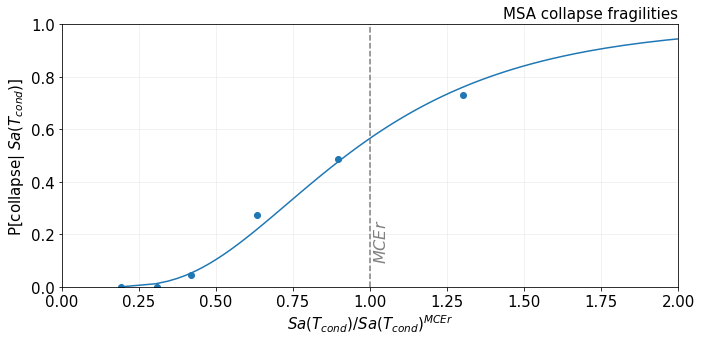

In [22]:
plot = False

title_text = 'MSA collapse fragilities'
fig, ax = plt.subplots(1,1, figsize=(10,5))     
y = np.linspace(0.001, 1, num=100)

collapse_metrics = {}

# Identify building name
# Get Sa(Tcond) for this building
stripe_values = []
for rp in rp_list:
    stripe_values.append(bldg_info['SaT_' + rp].iloc[case_i])

# Ger MCEr IM for this buiding
Sa_MCEr = bldg_info['Sa_MCEr'].iloc[case_i]

# pair return periods with results and the corresponding stripe IM value 
stripe_values_curr = []
pc_curr = []
for rp in rp_list:
    rp_i = np.argwhere(np.array(rp_list) == rp)[0][0]
    stripe_values_curr.append(stripe_values[rp_i])
    pc_curr.append(Pc[rp_i])    
stripe_values_curr = np.array(stripe_values_curr)
pc_curr = np.array(pc_curr)

# Compute and plot collapse fragility
mu, beta = compute_msa_fragility(pc_curr, stripe_values_curr, plot)

# inflate beta to account for additional uncertainty
if beta > 0.1: # small beta means not enough stripes in high intensities, so leave as is
    beta_adjusted = np.sqrt(beta**2 + betaDR**2 + betaTD**2 + betaMDL**2)
else:
    beta_adjusted = beta

x = stats.lognorm(beta, scale=mu).ppf(y)
_ = ax.plot(x/Sa_MCEr, y) # color=color_specs[case_i]

_ = plt.scatter(stripe_values_curr/Sa_MCEr, pc_curr) # edgecolor=color_specs[case_i], facecolor='none'

collapse_metrics['median'] = mu
collapse_metrics['beta'] = beta
collapse_metrics['beta_adjusted'] = beta_adjusted

_ = ax.grid(which='both', alpha=0.2)
_ = ax.set_xlim([0, 2])
_ = ax.set_ylim([0, 1])
_ = ax.set_xlabel(r'$Sa(T_{cond})/Sa(T_{cond})^{MCEr}$')
_ = ax.set_ylabel(r'P[collapse| $Sa(T_{cond}$)]')
_ = ax.set_title(title_text, loc='right')

# Add MCEr and DBE intensities
_ = ax.plot([Sa_MCEr/Sa_MCEr, Sa_MCEr/Sa_MCEr], [0, 1], '--', color='grey')
_ = ax.text(Sa_MCEr/Sa_MCEr+0.008, 0.1,'$MCEr$', rotation=90, fontsize=16, color='grey')

plt.tight_layout()
_ = plt.show()
_ = fig.savefig('3_Output_figures/CollapseFragility.png', transparent=True) 